In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit, float64
import time
import os
import copy

In [4]:
def load_excel_data(directory):
    """
    Load all Excel files and their sheets from the specified directory into a list of dataframes.

    Parameters:
    directory (str): The path to the folder containing the Excel files.

    Returns:
    list: A list of pandas dataframes containing the data from each sheet in the Excel files.
    """
    # Initialize an empty list to store dataframes
    datasets = []
    # Iterate over each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".xlsx"):
            file_path = os.path.join(directory, filename)

            # Load the Excel file
            excel_file = pd.ExcelFile(file_path)

            # Iterate over each sheet in the Excel file
            i = 0
            for sheet_name in excel_file.sheet_names:
                if i > 0:
                    break
                # Load the sheet into a dataframe and append to the datasets list
                df = pd.read_excel(excel_file, sheet_name=sheet_name)
                datasets.append(df)
                i += 1

    return datasets


def save_datasets_to_excel(datasets, output_file):
    """
    Save a list of dataframes to a single Excel file with each dataframe in a separate sheet.

    Parameters:
    datasets (list): A list of tuples containing filename, sheet name, and dataframe.
    output_file (str): The path to the output Excel file.
    """
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        for i, (df) in enumerate(datasets):
            sheet_name_clean = f"Sheet_{i}"[
                :31
            ]  # Excel sheet names must be <= 31 chars
            df.to_excel(writer, sheet_name=sheet_name_clean, index=False)

In [5]:
# Example usage of the function
directory = "data/"
datasets = load_excel_data(directory)

In [6]:
# for i in range(len(datasets)):
#     plt.plot(datasets[i]['timestamp'], datasets[i]['trolley_position'], label='Trolley Position')
#     plt.plot(datasets[i]['timestamp'], datasets[i]['cable_length'], label='Cable Length')
#     plt.xlabel('Time')
#     plt.title(f"Data Set {i+1}")
#     plt.legend()
#     plt.show()

In [7]:
DURATION = 15  # duration in seconds
DT = 0.0001  # time increment in seconds
# Create a time array
time_array = np.arange(0, DURATION + DT, DT)
NUM_STEPS = len(time_array)

interpolated_datasets = []
for i in range(len(datasets)):
    new_trolley_position = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_position"]
    )
    new_cable_length = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["cable_length"]
    )
    new_sway_angle = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["sway_angle"]
    )
    new_trolley_motor_voltage = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_motor_voltage"]
    )
    new_hoist_motor_voltage = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["hoist_motor_voltage"]
    )

    interpolated_df = {
        "time": time_array,
        "trolley_position": new_trolley_position,
        "cable_length": new_cable_length,
        "sway_angle": new_sway_angle,
        "trolley_motor_voltage": new_trolley_motor_voltage,
        "hoist_motor_voltage": new_hoist_motor_voltage,
    }

    interpolated_datasets.append(interpolated_df)

In [8]:
# for i in range(len(interpolated_datasets)):
# plt.plot(interpolated_datasets[i]['time'], interpolated_datasets[i]['trolley_position'], label='Trolley Position')
# plt.plot(interpolated_datasets[i]['time'], interpolated_datasets[i]['cable_length'], label='Cable Length')
# plt.xlabel('Time')
# plt.title(f"Interpolated Data Set {i+1}")
# plt.legend()
# plt.show()

In [9]:
# Open the JSON file
with open("gantry_crane_parameters.json", "r") as file:
    data = json.load(file)

global all_parameters
all_parameters = data["gantry_crane_system_model"]["parameters"]
measured_parameters = {}
approximated_parameters = {}

for parameter in all_parameters:
    value = all_parameters[parameter]["value"]
    unit = all_parameters[parameter]["unit"]
    description = all_parameters[parameter]["description"]

    # print(f"{parameter}: {value} {unit} ({description})")

    if all_parameters[parameter]["measured"]:
        measured_parameters[parameter] = all_parameters[parameter]
    else:
        approximated_parameters[parameter] = all_parameters[parameter]

print(f"Number of approximated parameters: {len(approximated_parameters)}")

Number of approximated parameters: 13


In [10]:
from model import Simulator
import utility as util

simulator = Simulator(DT, NUM_STEPS)

In [11]:
def cost_function(params, data_arrs):
    """
    Cost function is the sum of the root mean squared errors between the interpolated data and the simulated data.
    """
    # Extract the parameters
    input_voltages = {
        "trolley_motor_voltage": data_arrs["trolley_motor_voltage"],
        "hoist_motor_voltage": data_arrs["hoist_motor_voltage"],
    }
    var_init_conditions = {
        "x": data_arrs["trolley_position"][0],
        "l": data_arrs["cable_length"][0],
        "theta": data_arrs["sway_angle"][0],
    }
    # print(f"Simulating with parameters: {params}")
    # print(f"Inital conditions: {var_init_conditions}")

    simulator.simulate(params, input_voltages, var_init_conditions)
    simulation_results = simulator.get_results()

    # Convert simulation results and data arrays from dictionary to simple list
    simulation_results_arr = [simulation_results[key] for key in simulation_results]
    data_arrs_arr = [data_arrs[key] for key in data_arrs]

    sum_RMSE = util.calculate_sum_root_mean_squared_errors(
        simulation_results_arr, data_arrs_arr
    )

    if np.isnan(sum_RMSE):
        print(f"Sum RMSE is NaN")
        return np.inf

    print(" " * 100, end="\r")
    print(f"\rSum RMSE: \t{round(sum_RMSE, 5)}", end="\r")

    return sum_RMSE

In [12]:
optimize_range = {
    "trolley_mass": (1.0, 5.0),  # Done
    "trolley_damping_coefficient": (0.1, 10.0),  # Done
    "cable_damping_coefficient": (0.1, 10.0),  # Done
    "trolley_motor_rotator_inertia": (0.00001, 0.001),  # Done
    "trolley_motor_damping_coefficient": (0.1, 10.0),
    "trolley_motor_back_emf_constant": (0.001, 0.1),  # Done
    "trolley_motor_torque_constant": (0.01, 1.0),  # Done
    "hoist_motor_rotator_inertia": (0.000001, 0.0001),  # Done
    "hoist_motor_damping_coefficient": (0.1, 10.0),
    "hoist_motor_back_emf_constant": (0.01, 1.0),  # Done
    "hoist_motor_torque_constant": (0.0001, 0.01),  # Done
    "trolley_motor_activation_threshold_voltage": (0.1, 10.0),  # Done
    "hoist_motor_activation_threshold_voltage": (0.1, 10.0),  # Done
}

### Gradient Descent

In [13]:
LEARNING_RATE = 0.1
MAX_VARIATIONS = 1
MAX_ITERATIONS = 1000
NUM_DATASETS = len(interpolated_datasets)
# NUM_DATASETS = 3
print(f"Number of datasets: {NUM_DATASETS}")

Number of datasets: 13


In [14]:
best_parameters = copy.deepcopy(all_parameters)
best_average_cost = 0
for i in range(NUM_DATASETS):
    best_average_cost += cost_function(best_parameters, interpolated_datasets[i])
    print(f"Best Cost: {best_average_cost/NUM_DATASETS}", end="\r")
best_average_cost /= NUM_DATASETS
print(f"Best Average Cost: {best_average_cost}")

Best Average Cost: 0.4360764695552624                                                               


In [15]:
# Open the JSON file "GD_current_gantry_crane_parameters.json"
with open("GD_current_gantry_crane_parameters.json", "r") as file:
    data = json.load(file)

for parameter in all_parameters:
    all_parameters[parameter]["value"] = data[parameter]["value"]

In [16]:
variation = 0
while variation <= MAX_VARIATIONS:
    current_parameters = copy.deepcopy(all_parameters)
    if variation > 0:
        for parameter in approximated_parameters:
            current_parameters[parameter]["value"] = np.random.uniform(
                optimize_range[parameter][0], optimize_range[parameter][1]
            )
    print(f"Variation: {variation}")
    for parameter in approximated_parameters:
        print(f"{parameter}: {current_parameters[parameter]['value']}", end=" | ")
    print()

    diverge = False
    for iteration in range(MAX_ITERATIONS):
        print(f"\033[92mIteration: {iteration}\033[0m")

        # Loop through each parameter to optimize
        for parameter in approximated_parameters:
            if diverge:
                break

            # Loop through each dataset to calculate the cost and gradient
            average_parameter_gradient = 0
            average_cost = 0
            for dataset_num in range(NUM_DATASETS):
                if diverge:
                    break

                print(f"Optimizing {parameter} for dataset {dataset_num}", end="\r")

                # Calculate the cost function
                cost = cost_function(
                    current_parameters, interpolated_datasets[dataset_num]
                )

                if cost == np.inf:
                    print(f"\033[91mCost is infinite\033[0m")
                    time.sleep(5)
                    diverge = True
                    break

                average_cost += cost

                # Calculate the gradient
                new_parameters = copy.deepcopy(current_parameters)
                h = optimize_range[parameter][0] / 10e9
                new_parameters[parameter]["value"] += (
                    optimize_range[parameter][0] / 10e9
                )
                new_cost = cost_function(
                    new_parameters, interpolated_datasets[dataset_num]
                )
                gradient = (new_cost - cost) / h
                average_parameter_gradient += gradient

            # Update the parameter
            average_parameter_gradient /= NUM_DATASETS
            current_parameters[parameter]["value"] -= (
                average_parameter_gradient * LEARNING_RATE
            )

            if current_parameters[parameter]["value"] < 0:
                current_parameters[parameter]["value"] = optimize_range[parameter][0]

            average_cost /= NUM_DATASETS
            print(
                f"{parameter} || Cost: {average_cost}, Gradient: {average_parameter_gradient}, New Value: {current_parameters[parameter]['value']}"
            )
            print("-" * 100)

        if diverge:
            break

        else:
            average_final_cost = 0
            for dataset_num in range(NUM_DATASETS):
                average_final_cost += cost_function(
                    current_parameters, interpolated_datasets[dataset_num]
                )
            average_final_cost /= NUM_DATASETS

            if average_final_cost < best_average_cost:
                best_average_cost = average_final_cost
                best_parameters = copy.deepcopy(current_parameters)
                print(f"New Best Cost: {best_average_cost}")
                print(best_parameters)

                # Save the best parameters to a JSON file
                with open("GD_best_gantry_crane_parameters.json", "w") as file:
                    json.dump(best_parameters, file, indent=4)
        
        # Save the current parameters to a JSON every 10 iterations
        if iteration % 10 == 0:
            with open("GD_current_gantry_crane_parameters.json", "w") as file:
                json.dump(current_parameters, file, indent=4)

    if diverge:
        variation -= 1
        if variation < 0:
            variation = 0
        print("Variation Failed. Restarting current variation...")
        print("*" * 100)
        for parameter in approximated_parameters:
            current_parameters[parameter]["value"] = np.random.uniform(
                optimize_range[parameter][0], optimize_range[parameter][1]
            )
        continue

    print(
        f"Results: Average Cost: {average_final_cost}, Best Average Cost: {best_average_cost}"
    )
    print(f"Best Parameters:", end=" ")
    for parameter in approximated_parameters:
        print(f"{parameter}: {best_parameters[parameter]['value']}", end=" | ")
    print()
    print("*" * 100)

    variation += 1

Variation: 0
trolley_mass: 4.464237613927108 | trolley_damping_coefficient: 0.1984045708480116 | cable_damping_coefficient: 2.7324745022395875 | hoist_motor_activation_threshold_voltage: 4.210709865149485 | hoist_motor_rotator_inertia: 0.28502941112972824 | hoist_motor_damping_coefficient: 1.7850733302735877 | hoist_motor_torque_constant: 0.5709362555896939 | hoist_motor_back_emf_constant: 0.5458713879106231 | trolley_motor_activation_threshold_voltage: 4.663363183333321 | trolley_motor_rotator_inertia: 0.027552071187816385 | trolley_motor_damping_coefficient: 8.884483970562977 | trolley_motor_torque_constant: 2.1335138670524114 | trolley_motor_back_emf_constant: 0.002825462857797134 | 
Iteration: 0
trolley_mass || Cost: 0.42216140081552295, Gradient: 8.540177112501205e-08, New Value: 4.464237605386931
----------------------------------------------------------------------------------------------------
trolley_damping_coefficient || Cost: 0.4221614008155197, Gradient: 6.405132834375902e

TypeError: 'NoneType' object is not iterable

Optimized Parameters:


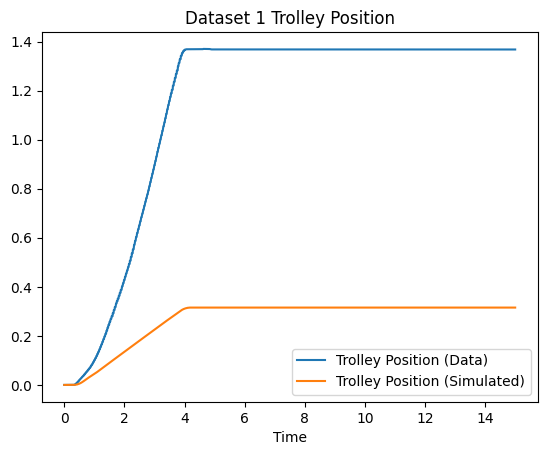

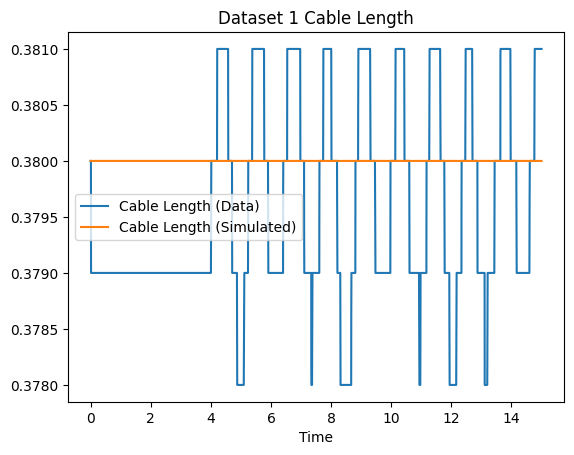

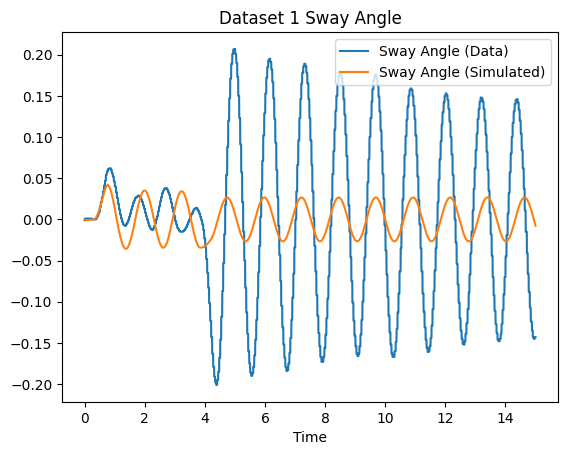

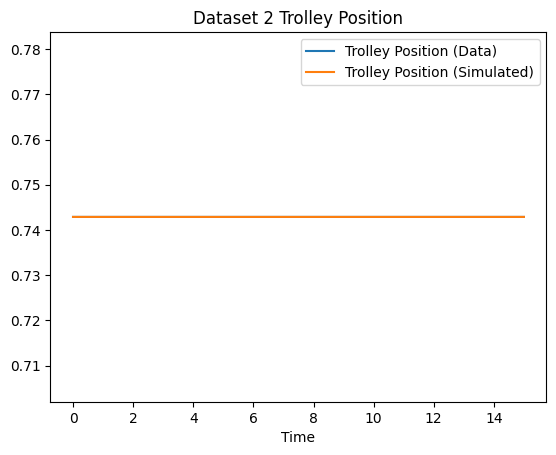

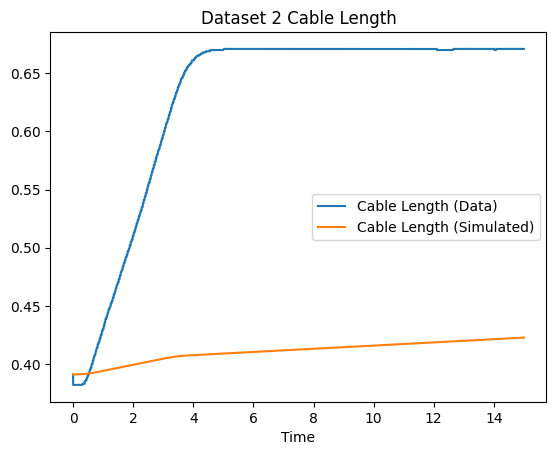

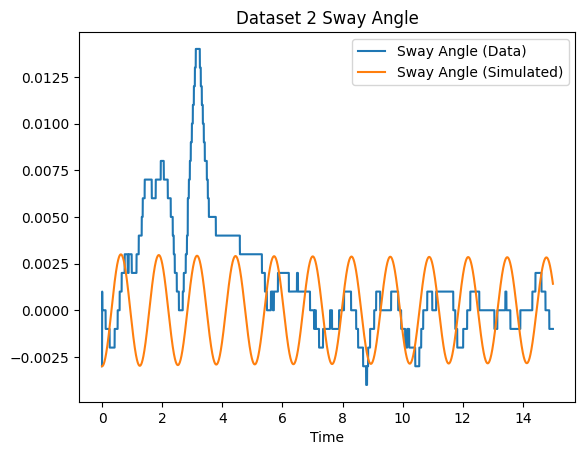

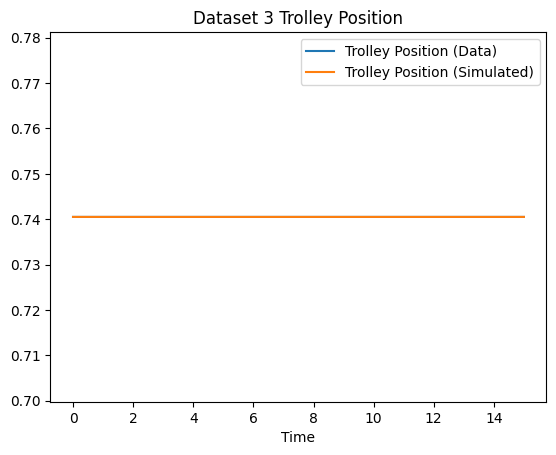

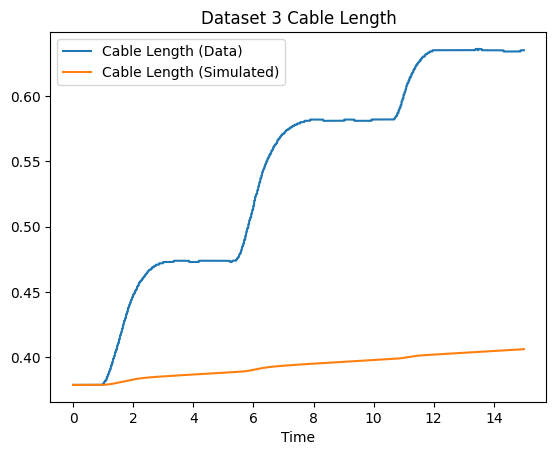

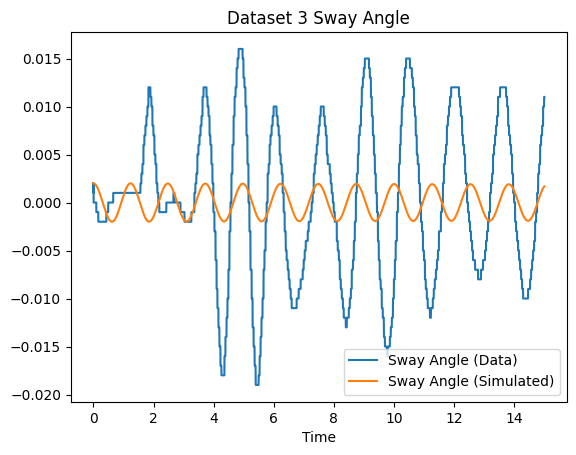

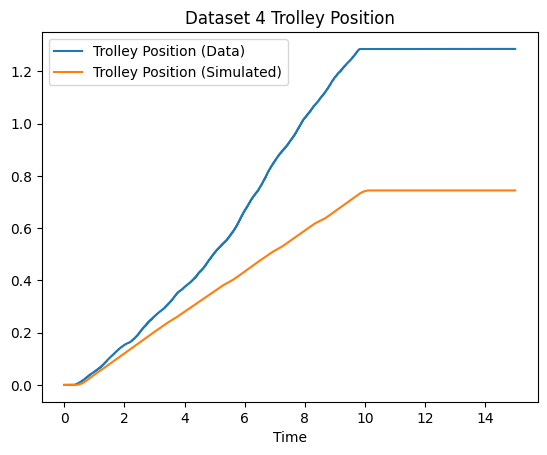

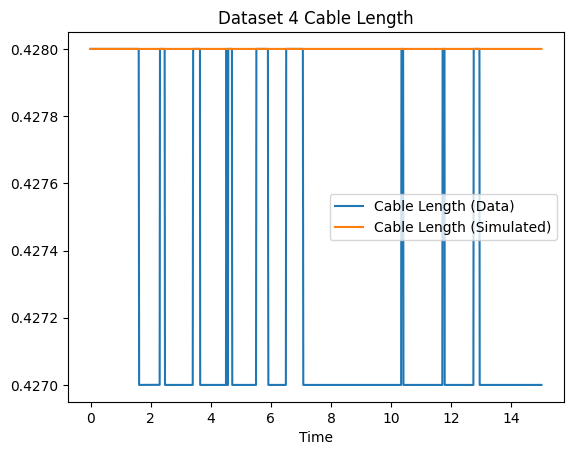

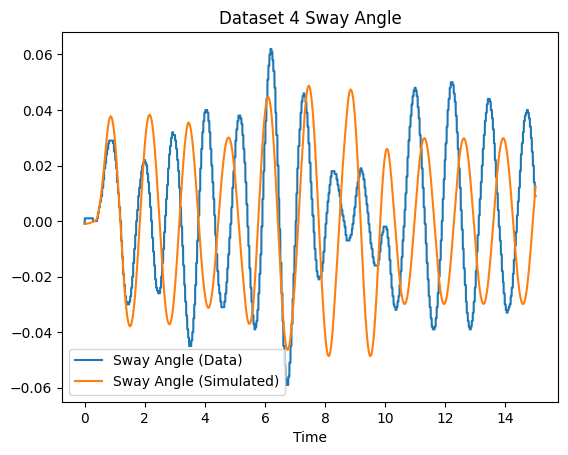

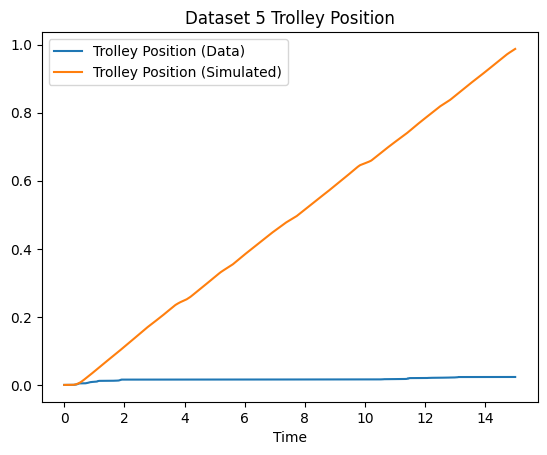

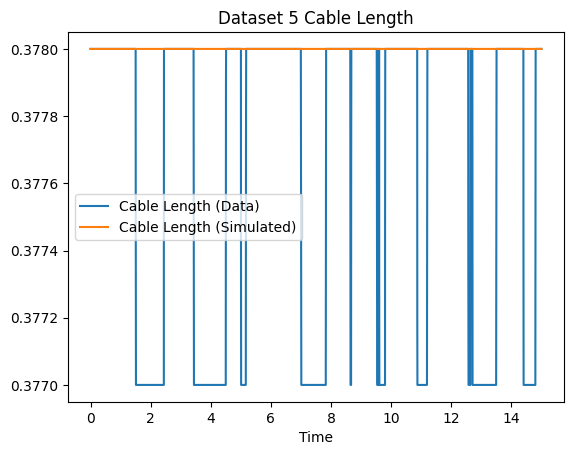

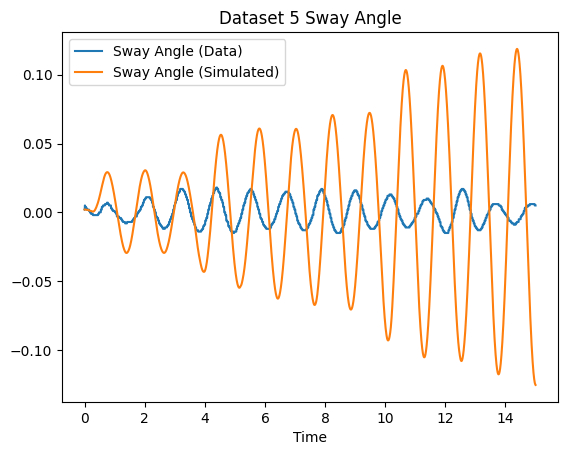

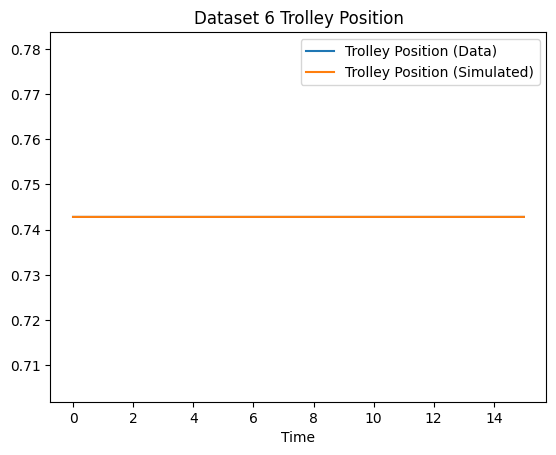

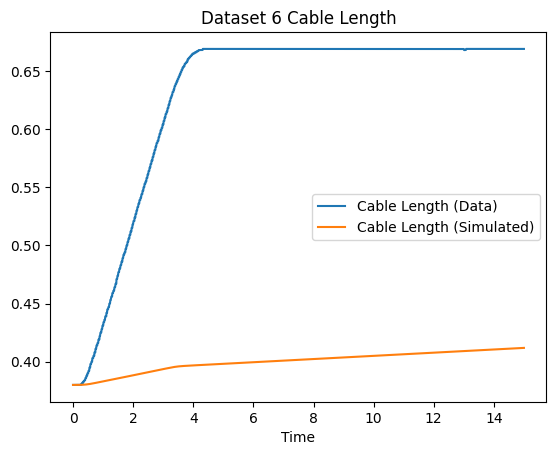

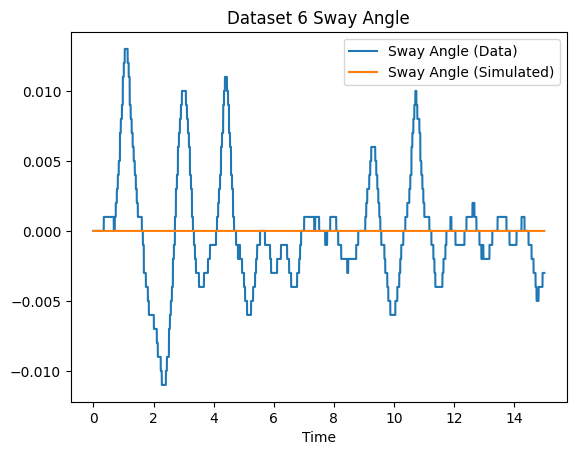

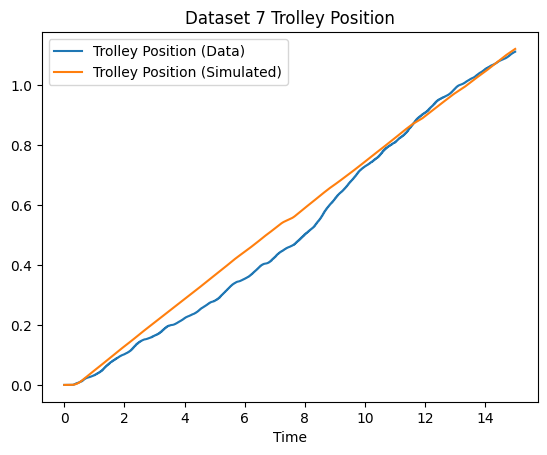

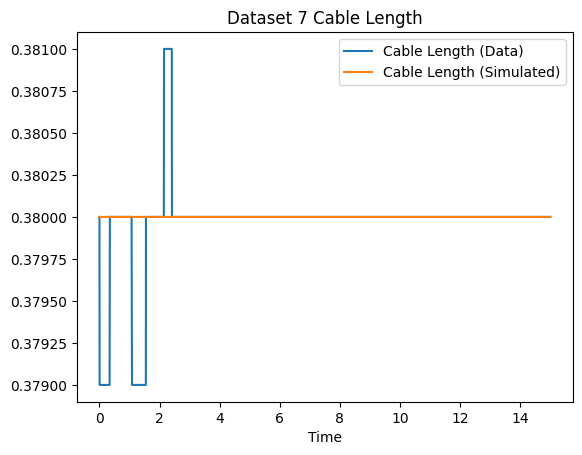

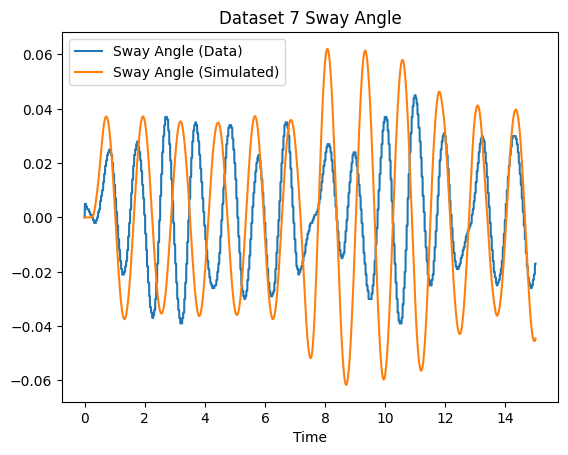

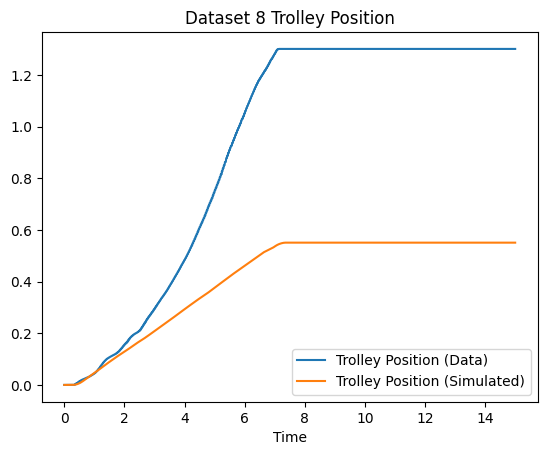

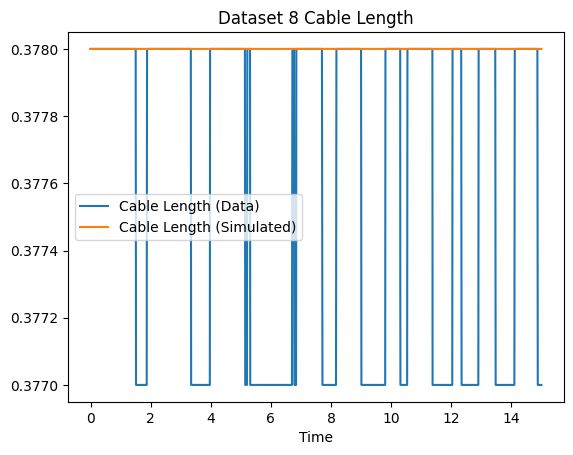

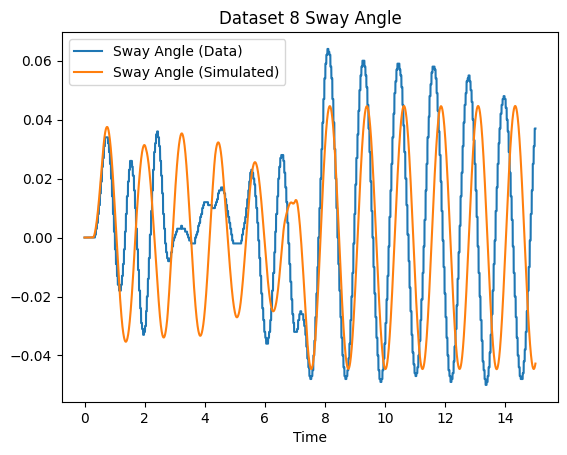

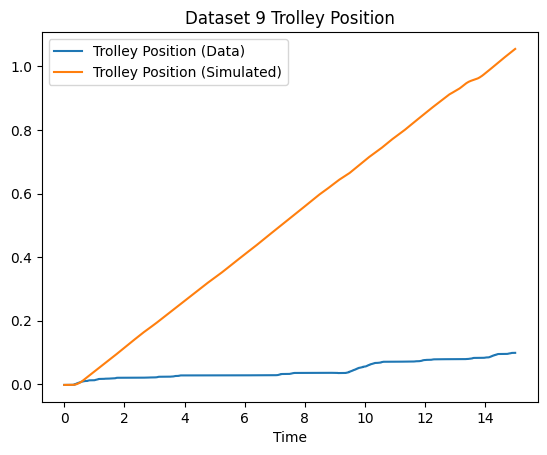

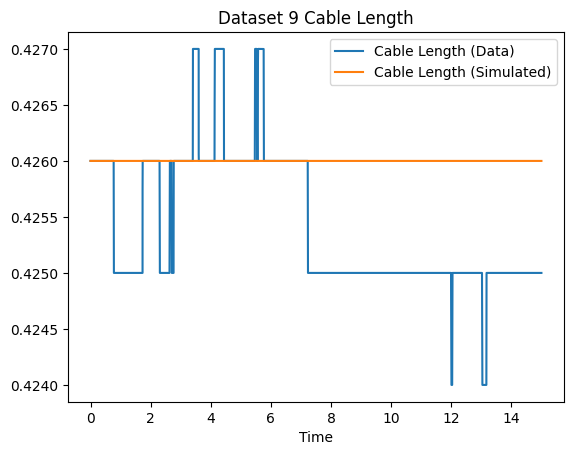

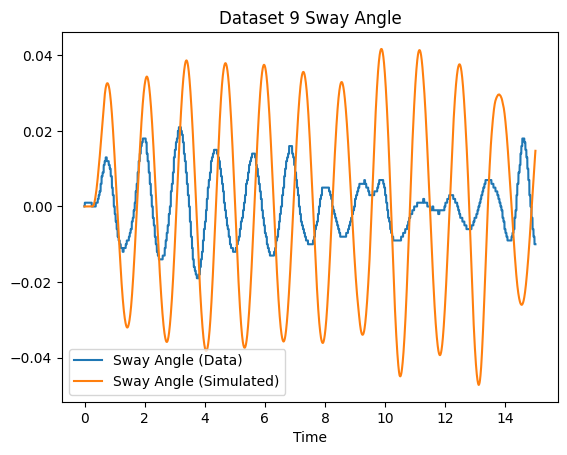

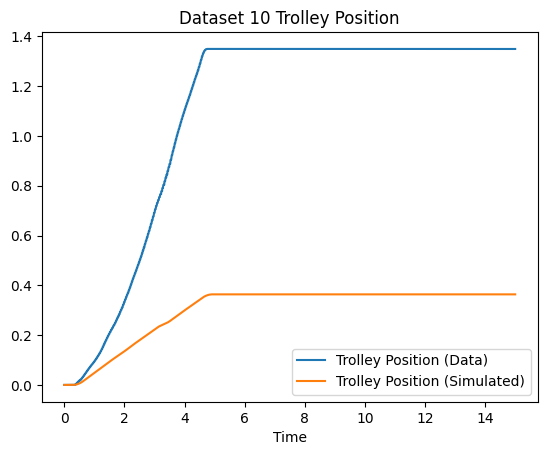

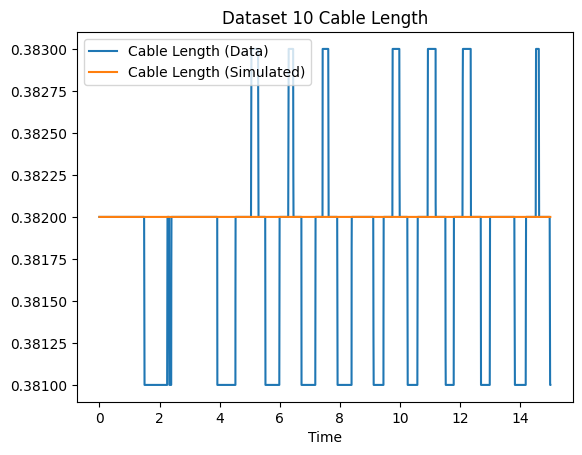

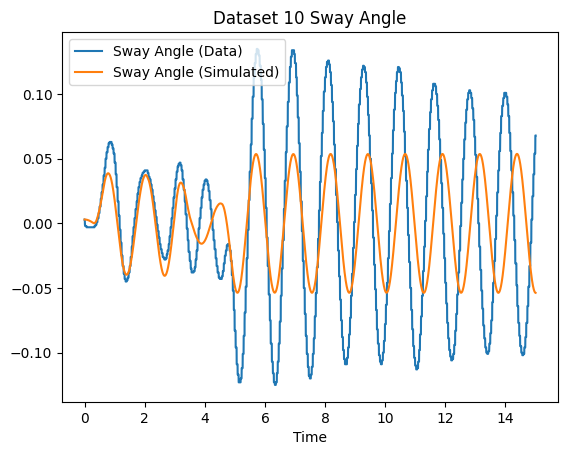

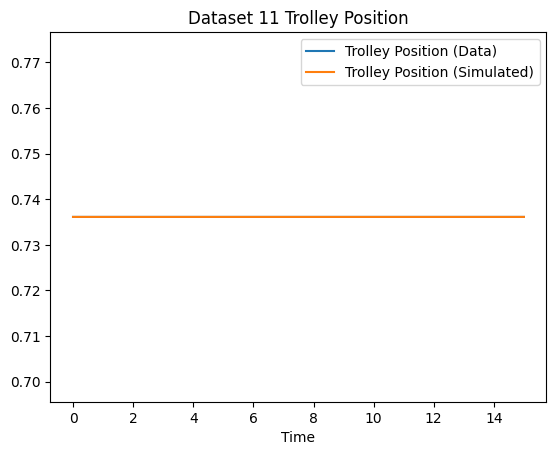

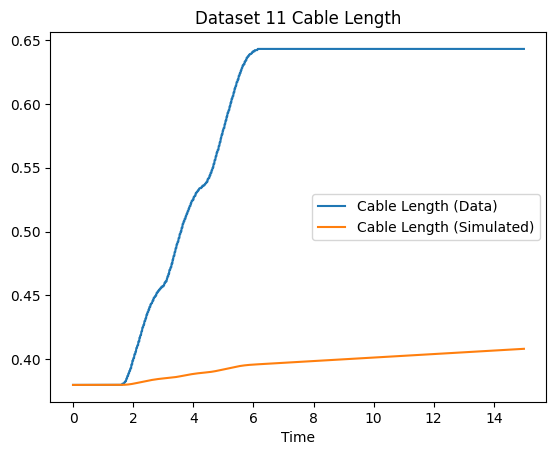

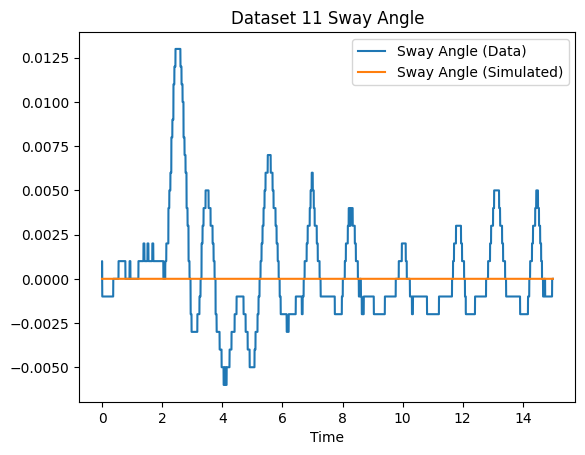

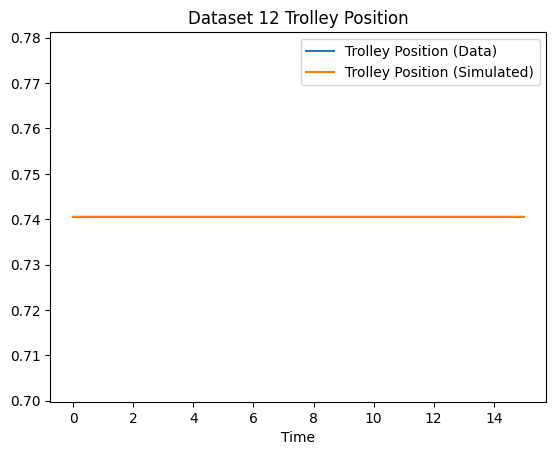

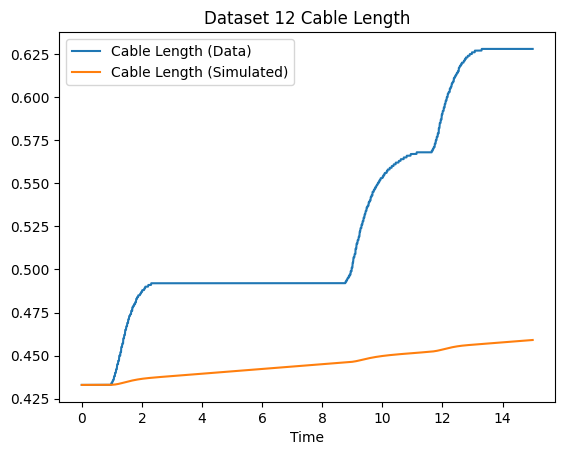

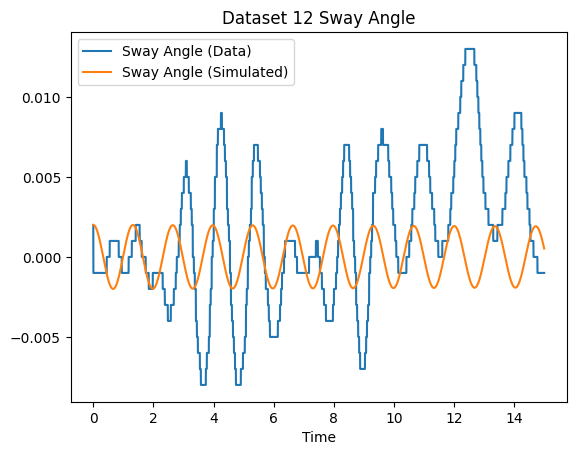

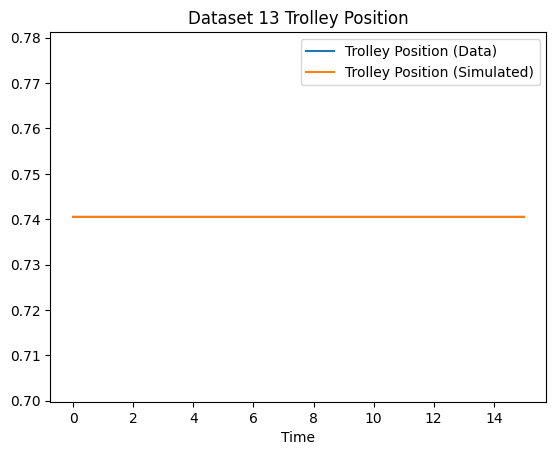

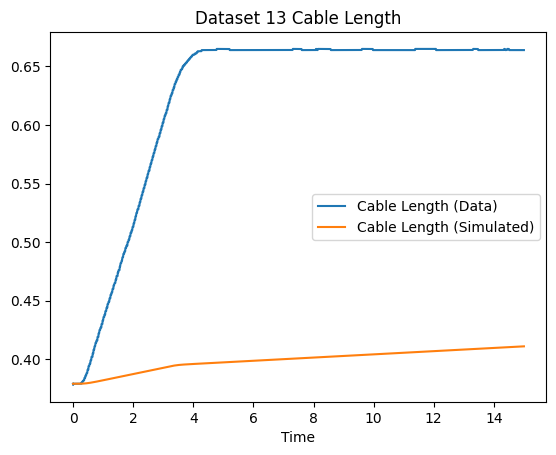

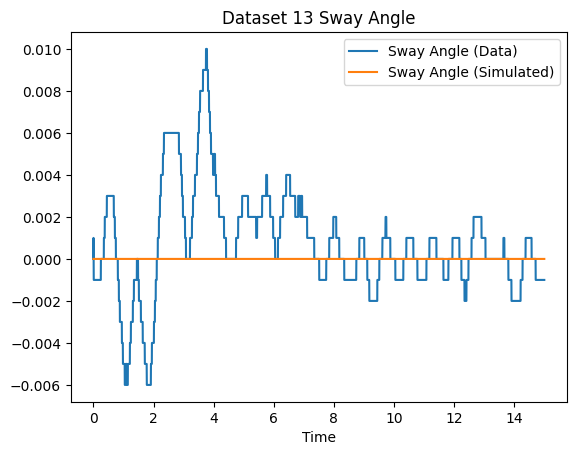

In [17]:
# Open the JSON file
with open("GD_best_gantry_crane_parameters.json", "r") as file:
    data = json.load(file)

optimized_parameters = data
print(f"Optimized Parameters:")

i = 0
for dataset in interpolated_datasets:
    # Extract the parameters
    input_voltages = {
        "trolley_motor_voltage": dataset["trolley_motor_voltage"],
        "hoist_motor_voltage": dataset["hoist_motor_voltage"],
    }
    var_init_conditions = {
        "x": dataset["trolley_position"][0],
        "l": dataset["cable_length"][0],
        "theta": dataset["sway_angle"][0],
    }

    simulator.simulate(optimized_parameters, input_voltages, var_init_conditions)
    simulation_results = simulator.get_results()

    # Plot the simulation results against the interpolated data
    plt.plot(
        dataset["time"], dataset["trolley_position"], label="Trolley Position (Data)"
    )
    plt.plot(
        dataset["time"],
        simulation_results["trolley_position"],
        label="Trolley Position (Simulated)",
    )
    plt.xlabel("Time")
    plt.title(f"Dataset {i+1} Trolley Position")
    plt.legend()
    plt.show()

    plt.plot(dataset["time"], dataset["cable_length"], label="Cable Length (Data)")
    plt.plot(
        dataset["time"],
        simulation_results["cable_length"],
        label="Cable Length (Simulated)",
    )
    plt.xlabel("Time")
    plt.title(f"Dataset {i+1} Cable Length")
    plt.legend()
    plt.show()

    plt.plot(dataset["time"], dataset["sway_angle"], label="Sway Angle (Data)")
    plt.plot(
        dataset["time"],
        simulation_results["sway_angle"],
        label="Sway Angle (Simulated)",
    )
    plt.xlabel("Time")
    plt.title(f"Dataset {i+1} Sway Angle")
    plt.legend()
    plt.show()

    i += 1